## 1. Answering Questions

#### The first things that comes to my mind are the Recurrent Neural Networks (RNNs) and Transformers. 

RNNs are a family of neural networks for analyzing sequential data. RNNs process sequences by iterating through the sequence elements and maintaining a state containing information about what the model has seen so far. One important model of RNNs is the Long Short Term Memory Model (LSTM), which leverages the Gate mechanism to determine which information the cell needs to remember and which to forget. However, RNNs including LSTM cannot be trained in parallel, so they are computationally expensive.

Transformers are also designed to handle sequential input data. However, unlike RNNs, transformers do not necessarily process the data in order. They learn contextual relations between words (or sub-words) in a text. Transformers adopt the mechanism of self-attention, which looks at an input sequence and decides at each step which other parts of the sequence are important. It resembles the human brain: When reading this text, you always focus on the word you read but at the same time your mind still holds the important keywords of the text in memory in order to provide context.

So, if the input data is a natural language sentence, the transformer does not need to process the beginning of the sentence before the end. Rather it identifies the context that confers meaning to each word in the sentence. This feature allows for more parallelization than RNNs and therefore reduces training times. The additional training parallelization allows training on larger datasets. It led to the development of pretrained systems such as Bidirectional Encoder Representations from Transformers (BERT) and Generative Pre-trained Transformer (GPT), which were trained with large language datasets and can be fine-tuned for specific tasks.

I also open the link in the doc and find that the question and answer are taken from the Stanford Question Answering Dataset (SQuAD). The work in (Wang and Jiang, 2016) was one of the first to investigate the dataset. The authors proposed an end-to-end architecture based on match-LSTM and pointer networks. (Seo et al., 2016) introduced the bi-directional attention flow network which captures the question-document context at different levels of granularity. 
(Wang et al., 2017) proposed a gated attention-based recurrent network where self-match attention mechanism is first incorporated. 

(Devlin et al., 2018) introduced BERT which is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be finetuned with just one additional output layer to create state-of-the-art models for a wide range of tasks including question answering.

#### The following are the demonstration of one pre-trained BERT model:

In [1]:
# !pip install transformers

In [2]:
# !pip install torch

In [3]:
import torch

For Question Answering we use the `BertForQuestionAnswering` class from the `transformers` library.

The `transformers` library has a large collection of pre-trained models which you can reference by name and load easily. The full list is in their documentation [here](https://huggingface.co/transformers/pretrained_models.html).

You can notice that there are also many pre-trained models in the bio domain.

For Question Answering, they have a version of BERT-large that has already been fine-tuned for the SQuAD benchmark.

In [4]:
from transformers import BertForQuestionAnswering

model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

Load the tokenizer as well. 

In [5]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

Input the question and answer.

In [6]:
question = "Which team won super bowl 50?"
answer_text = "Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24-10 to earn their third super bowl title. The game was played on February 7, 2016, at Levi’s Stadium in the San Francisco Bay Area at Santa Clara, California."

We'll need to run the BERT tokenizer against both the `question` and the `answer_text`.

In [7]:
inputs = tokenizer(question, answer_text, return_tensors="pt")

We now can feed our example into the model.


In [8]:
with torch.no_grad():
    outputs = model(**inputs)

We can highlight the answer just by looking at the most probable start and end words. 

In [9]:
# Find the tokens with the highest `start` and `end` scores.
answer_start_index = outputs.start_logits.argmax()
answer_end_index = outputs.end_logits.argmax()

In [10]:
predict_answer_tokens = inputs.input_ids[0, answer_start_index : answer_end_index + 1]
answer = tokenizer.decode(predict_answer_tokens)
print('Answer: "' + answer + '"')

Answer: "denver broncos"


## 2. Web scraping

Import necessary modules

In [11]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re

In [12]:
# Affiliations can only be found after collecting all URLs
def get_affiliations(URL_list):
    affiliation_list = []
    for url in URL_list:
        # Note that there is no author and corresponding affiliation info for corrections
        if 'corr' not in url:
            response_affiliation = requests.get(url + '.info')
            affiliation_page = BeautifulSoup(response_affiliation.content,'lxml')
            affiliations = ''
            odds = affiliation_page.find_all('li',{"class":'odd'})
            for odd in odds:
                affiliations = affiliations + "; " + odd.get_text()
            evens = affiliation_page.find_all('li',{"class":'even'})
            for even in evens:
                affiliations = affiliations + "; " + even.get_text()

            affiliations = affiliations[2:]
            affiliation_list.append(affiliations)
        else:
            affiliation_list.append(float('nan'))
    return affiliation_list 

# Define the function to extract data from the given volume and issue
def get_journals(volume = 10, issue = 3):
    output = pd.DataFrame()
    url = "https://jitc.bmj.com/content/{volume}/{issue}".format(volume = volume, issue = issue)
    response = requests.get(url)
    if response.status_code == 200:
        print("Success")
    else:
        print("Failure")
    results_page = BeautifulSoup(response.content,'lxml') 
    journals = results_page.find_all('div',{"class":re.compile('issue-toc-section issue-toc-section*')})
    journal_list = []
    authors = []
    for journal in journals:
        journal_list.extend(journal.find_all('a',{"class":'highwire-cite-linked-title'}))
        authors.extend(journal.find_all('div',{"class":'highwire-cite-authors'}))

    title_list = []
    author_list = []
    URL_list = []
    for journal in journal_list:
        title_list.append(journal.get_text())
        URL_list.append('https://jitc.bmj.com'+journal.get('href'))

    for author in authors:
        author_list.append(author.get_text())

    num_corrections = len(title_list) - len(author_list)
    for i in range(num_corrections):
        # corrections do not mention authors
        author_list.append(float('nan'))
    affiliation_list = get_affiliations(URL_list)   
    
    output['title'] = title_list
    output['authors'] = author_list
    output['affiliations'] = affiliation_list
    output['URL'] = URL_list
    
    return output

Please do not mind the warning.

The BeautifulSoup class was actually created to parse HTML files. However, the way that it parses HTML files involves coming up with a complex tree consisting of Python objects. This type of tree structure is applicable to XML files as well. Therefore, the BeautifulSoup class can also be used to parse XML files directly.

In [13]:
output = get_journals()

Success


/Users/sihanzhang/miniforge3_new/lib/python3.9/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


In [14]:
# The dataframe containing required info
output.head()

,title,authors,affiliations,URL
0,Original research: Unique characteristics of t...,"Tsukasa Masuda, Nobuyuki Tanaka, Kimiharu Taka...","Tsukasa Masuda Department of Urology, Keio Uni...",https://jitc.bmj.com/content/10/3/e003883
1,Original research: STAT3 inhibitor Napabucasin...,"Rebekka Bitsch, Annina Kurzay, Feyza Özbay Kur...",Rebekka Bitsch Skin Cancer Unit/ Department of...,https://jitc.bmj.com/content/10/3/e004384
2,Original research: TGFβ receptor inhibition un...,"Pauline Hamon, Marine Gerbé De Thoré, Marion C...","Pauline Hamon INSERM U1030, Gustave Roussy, Un...",https://jitc.bmj.com/content/10/3/e003519
3,IL-1R8 silencing improves the anti-tumor funct...,"Nadine Landolina, Francesca Romana Mariotti, T...","Nadine Landolina Immunology Research Area, Bam...",https://jitc.bmj.com/content/10/3/e003858
4,Original research: ZEB1 transcription factor p...,"Maud Plaschka, Valentin Benboubker, Maxime Gri...",Maud Plaschka Cancer Cell Plasticity in Melano...,https://jitc.bmj.com/content/10/3/e003484


In [15]:
# Save as csv
output.to_csv('/Users/sihanzhang/Desktop/journals.csv')

## 3. Data Preprocessing

In [2]:
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

In [3]:
# import training data
df_train = pd.read_csv('/Users/sihanzhang/Desktop/train.txt' , sep=';' , header=None)
df_train.columns = ['document', 'emotion']
df_train.head()

,document,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [4]:
# 1. getting rid of non-alphabet characters
def remove_nonalphabet(text):
    return re.sub(r'[^A-Za-z0-9 ]+', '', text)
df_train['document'] = df_train['document'].apply(lambda text: remove_nonalphabet(text))

In [5]:
# 2. converting to lowercase
df_train['document'] = df_train['document'].str.lower()

In [6]:
# 3. removing stop words
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df_train['document'] = df_train['document'].apply(lambda text: remove_stopwords(text))

In [7]:
# 4. performing lemmanization
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

df_train['document'] = df_train['document'].apply(lambda text: lemmatize_words(text))

In [8]:
df_train.head()

,document,emotion
0,didnt feel humiliate,sadness
1,go feeling hopeless damn hopeful around someon...,sadness
2,im grab minute post feel greedy wrong,anger
3,ever feel nostalgic fireplace know still property,love
4,feel grouchy,anger


In [9]:
# Define a function for data preprocessing
def preprocessing(df):
    df['document'] = df['document'].apply(lambda text: remove_nonalphabet(text))
    df['document'] = df['document'].str.lower()
    df['document'] = df['document'].apply(lambda text: remove_stopwords(text))
    df['document'] = df['document'].apply(lambda text: lemmatize_words(text))
    return df

In [10]:
# Load the test data
df_test = pd.read_csv('/Users/sihanzhang/Desktop/test.txt' , sep=';' , header=None)
df_test.columns = ['document', 'emotion']

In [11]:
df_test = preprocessing(df_test)
df_test.head()

,document,emotion
0,im feel rather rotten im ambitious right,sadness
1,im update blog feel shitty,sadness
2,never make separate ever want feel like ashamed,sadness
3,leave bouquet red yellow tulip arm feeling sli...,joy
4,feel little vain one,sadness


In [12]:
# Load the validation data
df_val = pd.read_csv('/Users/sihanzhang/Desktop/val.txt' , sep=';' , header=None)
df_val.columns = ['document', 'emotion']

In [13]:
df_val = preprocessing(df_val)
df_val.head()

,document,emotion
0,im feel quite sad sorry ill snap soon,sadness
1,feel like still look blank canvas blank piece ...,sadness
2,feel like faithful servant,love
3,feel cranky blue,anger
4,treat feeling festive,joy


## 4. Modeling

In [14]:
# !pip install -U keras

In [15]:
# !pip install tensorflow

In [16]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

In [17]:
X_train = df_train['document']
y_train = df_train['emotion']
X_test = df_test['document']
y_test = df_test['emotion']
X_val = df_val['document']
y_val = df_val['emotion']

In [18]:
# Encode labels

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [33]:
# Tokenize words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))


sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

X_train = pad_sequences(sequences_train, maxlen=256, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=256, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=256, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 13169


In [34]:
# Read GloVE embeddings

path_to_glove_file = '/Users/sihanzhang/Desktop/glove.6B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200
hits = 0
misses = 0
embeddings_index = {}

# Read word vectors
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))


# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 12054 words (1114 misses)


The result could be more robust if we set non-zero recurrent_dropout, but it would lead to a warning that Layer lstm_3 will not use cuDNN kernels since it doesn't meet the criteria. 

The requirements to use the cuDNN implementation are:

<li>activation == tanh
<li>recurrent_activation == sigmoid
<li>recurrent_dropout == 0
<li>unroll is False
<li>use_bias is True
<li>Inputs, if use masking, are strictly right-padded.
<li>Eager execution is enabled in the outermost context.

https://keras.io/api/layers/recurrent_layers/lstm/

If cuDNN is not enabled, it will cost too much training time.

Therefore, here I use zero recurrent_dropout as a demo.

In [35]:
# Build neural network architecture

adam = Adam(learning_rate=0.005)

model = Sequential()
model.add(Embedding(vocabSize, 200, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(256, dropout=0.2, recurrent_dropout=0, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0)))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Metal device set to: Apple M1 Pro


2022-05-16 18:25:09.304774: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-16 18:25:09.304883: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 200)          2633800   
                                                                 
 bidirectional (Bidirectiona  (None, 256, 512)         935936    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256, 256)         656384    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 1542      
                                                        

In [36]:
callback = EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True,
)

In [37]:
# Find optimal number of epochs
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_test, y_test),
                    verbose=1,
                    batch_size=256,
                    epochs=10,
                    callbacks=[callback]
                   )

Epoch 1/10


2022-05-16 18:25:10.245152: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-16 18:25:13.535204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-16 18:25:14.066683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-16 18:25:14.083270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-16 18:25:14.890508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-16 18:25:14.999586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-16 18:25:15.608553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113

63/63 [==============================] - ETA: 0s - loss: 1.1645 - accuracy: 0.5703

2022-05-16 18:27:04.764910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-16 18:27:04.958241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-16 18:27:04.972246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-16 18:27:05.946105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-16 18:27:06.049019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-16 18:27:06.689843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-16 18:27:06.699026: I tensorflow/core/grappler/optimizers/cust

63/63 [==============================] - 121s 2s/step - loss: 1.1645 - accuracy: 0.5703 - val_loss: 0.6926 - val_accuracy: 0.7575
Epoch 2/10
63/63 [==============================] - 110s 2s/step - loss: 0.5690 - accuracy: 0.8043 - val_loss: 0.4075 - val_accuracy: 0.8565
Epoch 3/10
63/63 [==============================] - 105s 2s/step - loss: 0.3409 - accuracy: 0.8753 - val_loss: 0.2615 - val_accuracy: 0.8925
Epoch 4/10
63/63 [==============================] - 113s 2s/step - loss: 0.2295 - accuracy: 0.9123 - val_loss: 0.2219 - val_accuracy: 0.9090
Epoch 5/10
63/63 [==============================] - 110s 2s/step - loss: 0.1702 - accuracy: 0.9263 - val_loss: 0.2162 - val_accuracy: 0.9050
Epoch 6/10
63/63 [==============================] - 109s 2s/step - loss: 0.1450 - accuracy: 0.9354 - val_loss: 0.2062 - val_accuracy: 0.9085
Epoch 7/10
63/63 [==============================] - 118s 2s/step - loss: 0.1187 - accuracy: 0.9442 - val_loss: 0.2265 - val_accuracy: 0.9040
Epoch 8/10
63/63 [======

In [38]:
model.evaluate(X_val, y_val, verbose=1)

63/63 [==============================] - 13s 192ms/step - loss: 0.2187 - accuracy: 0.9205


[0.21870341897010803, 0.9205000400543213]

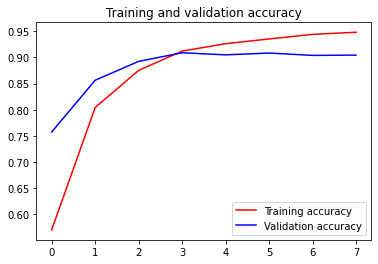

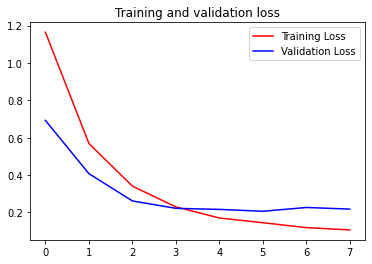

In [39]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [40]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

63/63 [==============================] - 11s 177ms/step - loss: 0.2348 - accuracy: 0.9045


In [41]:
y_pred = model.predict(X_test)

2022-05-16 18:40:30.571166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-16 18:40:30.764266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-16 18:40:30.772669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-16 18:40:31.311624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-16 18:40:31.320856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-16 18:40:31.817795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-16 18:40:31.826119: I tensorflow/core/grappler/optimizers/cust

In [42]:
rounded_y_test = np.argmax(y_test, axis=1)
rounded_y_pred = np.argmax(y_pred, axis=1)

In [43]:
accuracy_score(rounded_y_test, rounded_y_pred)

0.9045

In [44]:
precision_score(rounded_y_test, rounded_y_pred, average='weighted') 
# average{‘micro’, ‘macro’, ‘samples’,’weighted’, ‘binary’} or None, default=’binary’

0.9049154995484402

In [45]:
recall_score(rounded_y_test, rounded_y_pred, average='weighted')

0.9045

In [46]:
f1_score(rounded_y_test, rounded_y_pred, average='weighted')

0.9019670675179853